# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

### Homework 1 is due 2/13

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [195]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
import rpy2.robjects as robjects
import seaborn as sns
from rpy2.robjects.packages import importr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
r_utils = importr('utils')
r_predict = robjects.r["predict"]
# if there are errors about missing R packages, uncomment and run the lines below:
#r_utils.install_packages('codetools')
#r_utils.install_packages('gam')
r_splines = importr('splines')
r_smooth_spline = robjects.r['smooth.spline'] #extract R function
r_gam_lib = importr('gam')
r_gam = r_gam_lib.gam #extract R function
r_glm = robjects.r['glm'] #extract R function
r_lm = robjects.r['lm'] #extract R function
r_anova = robjects.r['anova'] #extract R function

In [137]:
R = robjects.r

# Get the default memory allocated to R
print(f'Default memory available to R in MB:')
print(R('memory.limit()'))

# Increase memory to a big number
R('memory.limit(size = 3000)')

# Report new memory availability
print('Memory available after increase:')
print(R('memory.limit()'))

Default memory available to R in MB:
[1] 3000

Memory available after increase:
[1] 3000




<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for Airbnb units in the Boston area from 2017 to 2018. Note that some of the rows in the `.csv` file refer to dates in the future. These refer to bookings that have been made far in advance.

Start by loading the data using pandas:

In [138]:
#your code here
calendar_train = pd.read_csv('data\calendar_train.csv').dropna()
display(calendar_train.dtypes)
display(calendar_train.shape)

listing_id      int64
date           object
available      object
price         float64
dtype: object

(309288, 4)

### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

*Hint*: You will want to first convert the `date` column into Python dates using `datetime.datetime.strptime(arg1,arg2).date()` and providing the appropriate arguments.

In [139]:
#your code here
def get_date(x):
    return(datetime.datetime.strptime(x, '%m/%d/%y').date())

def get_month(x):
    return(datetime.datetime.strftime(x, '%b'))

def get_day(x):
    return(datetime.datetime.strftime(x, '%a'))

In [140]:
calendar_train['date_new'] = calendar_train['date'].apply(get_date)
calendar_train['month'] = calendar_train['date_new'].apply(get_month)
calendar_train['day'] = calendar_train['date_new'].apply(get_day)
calendar_train.head()

,listing_id,date,available,price,date_new,month,day
123,20872145,4/2/18,t,62.0,2018-04-02,Apr,Mon
124,20872145,4/1/18,t,59.0,2018-04-01,Apr,Sun
125,20872145,3/31/18,t,75.0,2018-03-31,Mar,Sat
126,20872145,3/30/18,t,71.0,2018-03-30,Mar,Fri
127,20872145,3/28/18,t,51.0,2018-03-28,Mar,Wed


In [141]:
df_gb_mo = pd.DataFrame(calendar_train.groupby(by='month')['price'].mean()).reset_index()
df_gb_d = pd.DataFrame(calendar_train.groupby(by='day')['price'].mean()).reset_index()

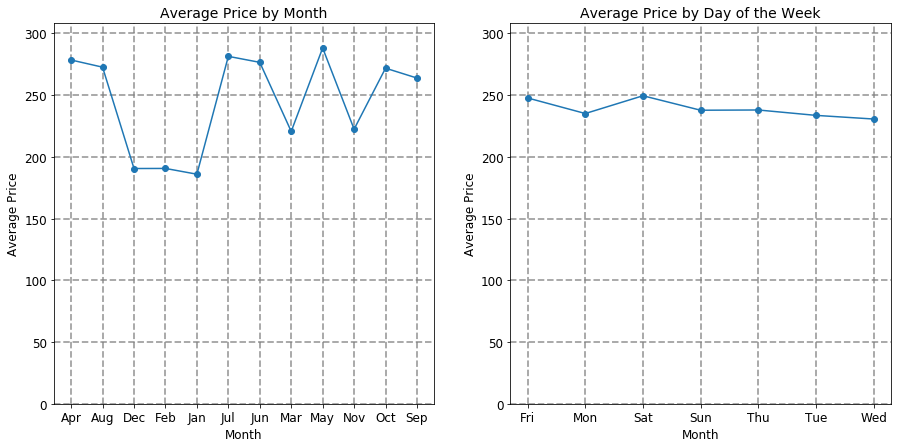

In [142]:
fig1, ax1 = plt.subplots(1, 2, figsize=(15,7))

ax1[0].plot(df_gb_mo['month'], df_gb_mo['price'], marker='o')
ax1[0].set_ylim(0, max(df_gb_mo['price'])+20)
ax1[0].set_xlabel('Month', fontsize=12)
ax1[0].set_ylabel('Average Price', fontsize=12)
ax1[0].set_title('Average Price by Month', fontsize=14)
ax1[0].grid(True, lw = 1.75, ls = '--', color ='grey', alpha = 0.75)
ax1[0].tick_params(labelsize = 12)

ax1[1].plot(df_gb_d['day'], df_gb_d['price'], marker='o')
ax1[1].set_ylim(0, max(df_gb_mo['price'])+20)
ax1[1].set_xlabel('Month', fontsize=12)
ax1[1].set_ylabel('Average Price', fontsize=12)
ax1[1].set_title('Average Price by Day of the Week', fontsize=14)
ax1[1].grid(True, lw = 1.75, ls = '--', color ='grey', alpha = 0.75)
ax1[1].tick_params(labelsize = 12)

your explanation here

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the average price of an Airbnb rental on that date. For this part of the question, you can ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Regression models with different basis functions:
    * Simple polynomials with degrees 5, 25, and 50
    * Cubic B-splines with the knots chosen by visual inspection of the data
    * Natural cubic splines with the degree of freedom chosen by cross-validation on the training set.
    
2. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

In each case, analyze the effect of the relevant tuning parameters on the training and test $R^2$ and give explanations for what you observe.

Is there a reason you would prefer one of these methods over the other (hint: you may want to consider $R^2$)?

*Hint*: The functions `bs` (for B-spline basis functions) and `ns` (for natural cubic spline basis functions) are available  in the `r_splines` library.


In [143]:
#your code here
min_day = calendar_train['date_new'].min()

def get_date_diff(x, min_day=min_day):
    return(abs(x-min_day).days)

calendar_train['date_diff_min'] = calendar_train['date_new'].apply(get_date_diff)
train_gb = pd.DataFrame(calendar_train.groupby(by=['date_diff_min', 'day', 'date_new']).mean()['price']).reset_index()

In [144]:
calendar_test = pd.read_csv('data\calendar_test.csv').dropna()
calendar_test['date_new'] = calendar_test['date'].apply(get_date)
calendar_test['month'] = calendar_test['date_new'].apply(get_month)
calendar_test['day'] = calendar_test['date_new'].apply(get_day)
calendar_test['date_diff_min'] = calendar_test['date_new'].apply(get_date_diff)
test_gb = pd.DataFrame(calendar_test.groupby(by=['date_diff_min', 'day','date_new']).mean()['price']).reset_index()

In [145]:
# declare R objects

def get_robj(train, test):
    r_date_train = robjects.FloatVector(train[['date_diff_min']].values)
    r_price_train = robjects.FloatVector(train[['price']].values)
    r_date_test = robjects.FloatVector(test[['date_diff_min']].values)
    r_price_test = robjects.FloatVector(test[['price']].values)
    train_df = robjects.DataFrame({'date_diff_min': r_date_train})
    predict_df = robjects.DataFrame({'date_diff_min': r_date_test})
    return(r_date_train, r_price_train, r_date_test, r_price_test, train_df, predict_df)

def fit_model(x, y, r_quarts: int=5, df: int=10, deg: int=5, model: str='glm'):
    # define formulas
    if model == 'glm':
        model_formula = robjects.Formula("price ~ poly(date_diff_min, r_degree_train, raw=TRUE)")
        model_formula.environment['r_degree_train'] = deg
    elif model == 'ns':
        model_formula = robjects.Formula("price ~ ns(date_diff_min, df=df)")
        model_formula.environment['df'] = df
    elif model == 'bs':
        model_formula = robjects.Formula("price ~ bs(date_diff_min, knots=r_quarts)")
        model_formula.environment['r_quarts'] = r_quarts
    model_formula.environment['date_diff_min'] = x
    model_formula.environment['price'] = y

    # fit the model
    model_fit = r_glm(model_formula, family='gaussian')    
    
    return(model_fit)

In [146]:
r_date_train, r_price_train, r_date_test, r_price_test, train_df, predict_df = get_robj(train_gb, test_gb)

### Polynomials

In [147]:
degree = list([5, 25, 50])
models = {}
r_pred_train = {}
r_pred_test = {}
r2 = {}
for i in range(len(degree)):
    models[degree[i]] = fit_model(x=r_date_train, y=r_price_train, deg=degree[i])
    r_pred_train[degree[i]] = r_predict(models[degree[i]], train_df)
    r_pred_train[degree[i]] = r_predict(models[degree[i]], predict_df)
    r2[degree[i]] = [r2_score(r_price_train, r_predict(models[degree[i]], train_df)), 
                     r2_score(r_price_test, r_predict(models[degree[i]], predict_df))]

Text(0.5, 1.0, 'Fitted Polynomials of Degrees 5, 25 and 50')

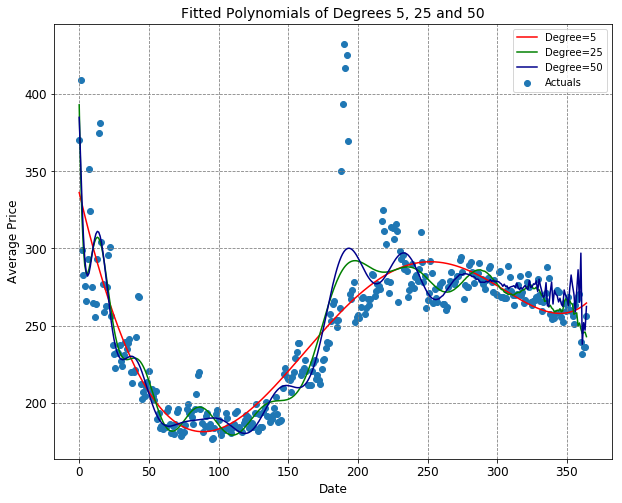

In [148]:
fig2, ax2 = plt.subplots(1,1, figsize=(10,8))
ax2.scatter(train_gb['date_diff_min'], train_gb['price'], label='Actuals')
ax2.plot(r_pred_train[5], label='Degree=%s'%5, c='red')
ax2.plot(r_pred_train[25], label='Degree=%s'%25, c='green')
ax2.plot(r_pred_train[50], label='Degree=%s'%50, c='darkblue')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Average Price', fontsize=12)
ax2.legend(loc='best')
ax2.grid(b=True, ls='--', color='grey')
ax2.tick_params(labelsize=12)
ax2.set_title('Fitted Polynomials of Degrees 5, 25 and 50', fontsize=14)

### B-Splines

In [149]:
r_quarts = robjects.FloatVector(np.quantile(r_date_train,[.25,.5,.75]))

models['bs'] = fit_model(x=r_date_train, y=r_price_train, r_quarts=r_quarts, model='bs')
r_pred_train['bs'] = r_predict(models['bs'], train_df)
r_pred_test['bs'] = r_predict(models['bs'], predict_df)
r2['bs'] = [r2_score(r_price_train, r_pred_train['bs']), 
            r2_score(r_price_test, r_pred_test['bs'])]

### Natural Splines

In [150]:
model = fit_model(x=r_date_train.rx(train), y=r_price_train.rx(train), df=10, model='ns')

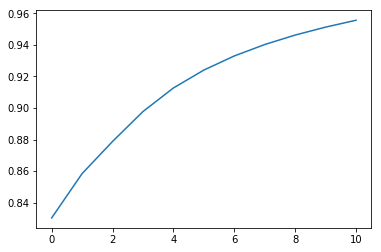

In [151]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
df = [25,50,75,100,125,150,175,200,225,250,275]
r2_ns = []
r2_ns_mean = []

for i in df:
    for train, test in kf.split(r_date_train):
        train = robjects.IntVector(train)
        test = robjects.IntVector(train)
        model = fit_model(x=r_date_train.rx(train), y=r_price_train.rx(train), df=i, model='ns')
        r2_ns.append(r2_score(r_price_train.rx(test), 
                              r_predict(model, robjects.DataFrame({'date_diff_min':r_date_train.rx(test)}))))
    r2_ns_mean.append(np.mean(r2_ns))
    
plt.plot(r2_ns_mean)

In [152]:
models['ns'] = fit_model(x=r_date_train, y=r_price_train, df=275, model='ns')
r_pred_train['ns'] = r_predict(models['ns'], train_df)
r_pred_test['ns'] = r_predict(models['ns'], predict_df)
r2['ns'] = [r2_score(r_price_train, r_pred_train['ns']), 
            r2_score(r_price_test, r_pred_test['ns'])]

Text(0.5, 1.0, 'Natural and B-Splines')

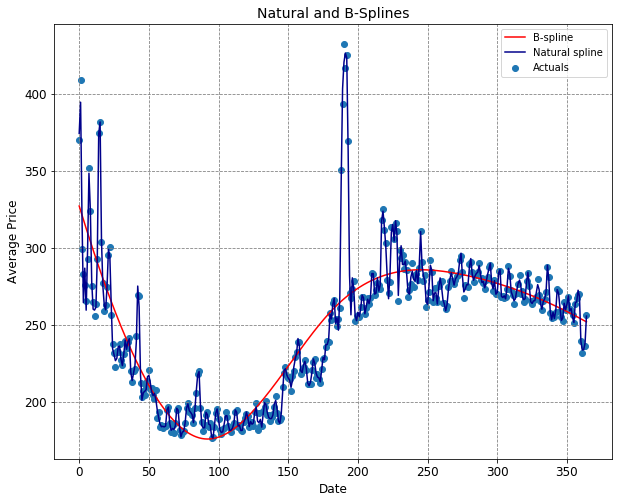

In [173]:
fig3, ax3 = plt.subplots(1,1, figsize=(10,8))
ax3.scatter(train_gb['date_diff_min'], train_gb['price'], label='Actuals')
ax3.plot(r_pred_train['bs'],color="red", label='B-spline')
ax3.plot(r_pred_train['ns'],color="darkblue", label='Natural spline')
ax3.set_xlabel('Date', fontsize=12)
ax3.set_ylabel('Average Price', fontsize=12)
ax3.legend(loc='best')
ax3.grid(b=True, ls='--', color='grey')
ax3.tick_params(labelsize=12)
ax3.set_title('Natural and B-Splines', fontsize=14)

your explanation here

### Smoothing Spline

In [154]:
models['ss'] = r_smooth_spline(r_date_train, r_price_train, cv=True) 
lambda_cv = models['ss'].rx2("lambda")[0]

r_pred_train['ss'] = r_predict(models['ss'], train_df)[1][0]
r_pred_test['ss'] = r_predict(models['ss'], predict_df)[1][0]
r2['ss'] = [r2_score(r_price_train, r_pred_train['ss']), 
            r2_score(r_price_test, r_pred_test['ss'])]

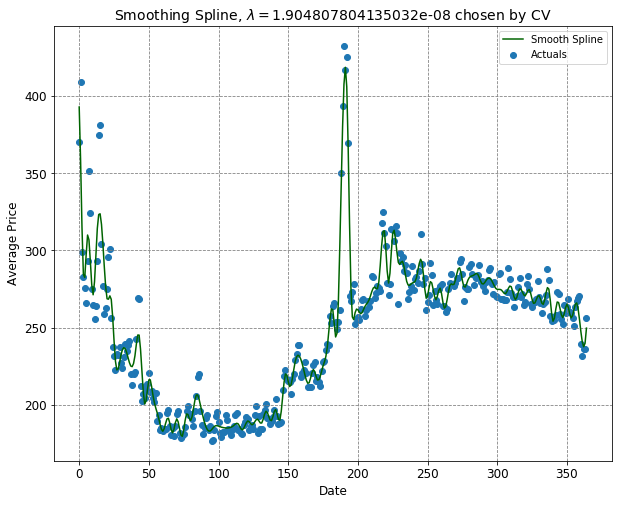

In [155]:
#your code here
fig4, ax4 = plt.subplots(1,1, figsize=(10,8))
ax4.scatter(train_gb['date_diff_min'], train_gb['price'], label='Actuals')
ax4.plot(r_pred_train['ss'], color="darkgreen", label='Smooth Spline')
ax4.set_xlabel('Date', fontsize=12)
ax4.set_ylabel('Average Price', fontsize=12)
ax4.legend(loc='best')
ax4.grid(b=True, ls='--', color='grey')
ax4.tick_params(labelsize=12)
ax4.set_title('Smoothing Spline, $\lambda=$'+str(lambda_cv)+' chosen by CV', fontsize=14);

In [156]:
r2_df = pd.DataFrame(r2, index=['Train', 'Test'])
r2_df

,5,25,50,bs,ns,ss
Train,0.716899,0.784584,0.791832,0.72513,0.995088,0.948685
Test,0.685017,0.741996,0.749740,0.69310,0.931236,0.909337


your explanation here

In [157]:
#your code here

your explanation here

In [158]:
#your code here

your explanation here

your explanation here

### Part 1b: Adapting to weekends

Does the pattern of Airbnb pricing differ over the days of the week? Are the patterns on weekends different from those on weekdays? If so, we might benefit from using a different regression model for weekdays and weekends. Split the training and test data into two parts, one for weekdays and one for weekends, and fit a separate model for each training subset. Do the models yield a higher $R^2$ on the corresponding test subsets compared to the model fitted previously?

In [159]:
#your code here
cond = (train_gb['day']=='Fri') | (train_gb['day']=='Sat')
wknd = robjects.BoolVector(cond)
wkdy = robjects.BoolVector(-cond)

train_wknd = robjects.DataFrame({'date_diff_min':train_df.rx(wknd, True)})
predict_wknd = robjects.DataFrame({'date_diff_min':predict_df.rx(wknd, True)})

train_wkdy = robjects.DataFrame({'date_diff_min':train_df.rx(wkdy, True)})
predict_wkdy = robjects.DataFrame({'date_diff_min':predict_df.rx(wkdy, True)})



degree = list([5, 25, 50])
models_wknd = {}
pr_train_wknd = {}
pr_test_wknd = {}
r2_wknd = {}
for i in range(len(degree)):
    models_wknd[degree[i]] = fit_model(x=r_date_train.rx(wknd), y=r_price_train.rx(wknd), deg=degree[i])
    pr_train_wknd[degree[i]] = r_predict(models_wknd[degree[i]], train_wknd)
    pr_test_wknd[degree[i]] = r_predict(models_wknd[degree[i]], predict_wknd)
    r2_wknd[degree[i]] = [r2_score(r_price_train.rx(wknd), pr_train_wknd[degree[i]]), 
                     r2_score(r_price_test.rx(wknd), pr_test_wknd[degree[i]])] 
    
r2_wknd_df = pd.DataFrame(r2_wknd, index=['Train', 'Test'])
r2_wknd_df

,5,25,50
Train,0.762186,0.841184,0.777715
Test,0.730308,0.807095,0.732489


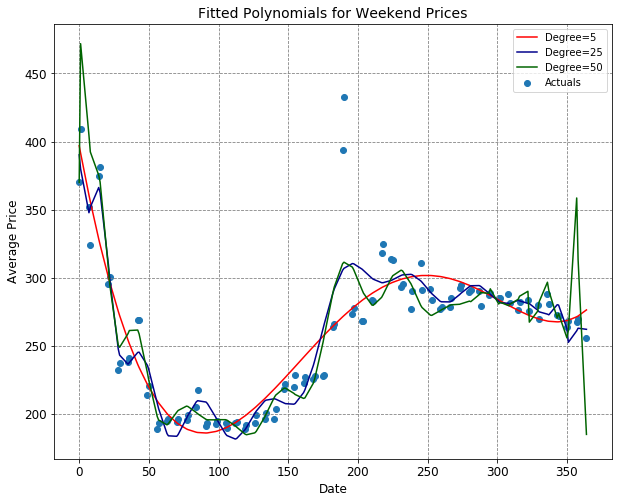

In [160]:
fig5, ax5 = plt.subplots(1,1, figsize=(10,8))
ax5.scatter(train_gb[cond]['date_diff_min'], train_gb[cond]['price'], label='Actuals')
ax5.plot(train_gb[cond]['date_diff_min'], pr_train_wknd[5], color="red", label='Degree=5')
ax5.plot(train_gb[cond]['date_diff_min'], pr_train_wknd[25], color="darkblue", label='Degree=25')
ax5.plot(train_gb[cond]['date_diff_min'], pr_train_wknd[50], color="darkgreen", label='Degree=50')
ax5.set_xlabel('Date', fontsize=12)
ax5.set_ylabel('Average Price', fontsize=12)
ax5.legend(loc='best')
ax5.grid(b=True, ls='--', color='grey')
ax5.tick_params(labelsize=12)
ax5.set_title('Fitted Polynomials for Weekend Prices', fontsize=14);

In [161]:
models_wkdy = {}
pr_train_wkdy = {}
pr_test_wkdy = {}
r2_wkdy = {}
for i in range(len(degree)):
    models_wkdy[degree[i]] = fit_model(x=r_date_train.rx(wkdy), y=r_price_train.rx(wkdy), deg=degree[i])
    pr_train_wkdy[degree[i]] = r_predict(models_wkdy[degree[i]], train_wkdy)
    pr_test_wkdy[degree[i]] = r_predict(models_wkdy[degree[i]], predict_wkdy)
    r2_wkdy[degree[i]] = [r2_score(r_price_train.rx(wkdy), pr_train_wkdy[degree[i]]), 
                     r2_score(r_price_test.rx(wkdy), pr_test_wkdy[degree[i]])] 
    
r2_wkdy_df = pd.DataFrame(r2_wkdy, index=['Train', 'Test'])
r2_wkdy_df

,5,25,50
Train,0.761919,0.823145,0.838893
Test,0.709991,0.759786,0.777033


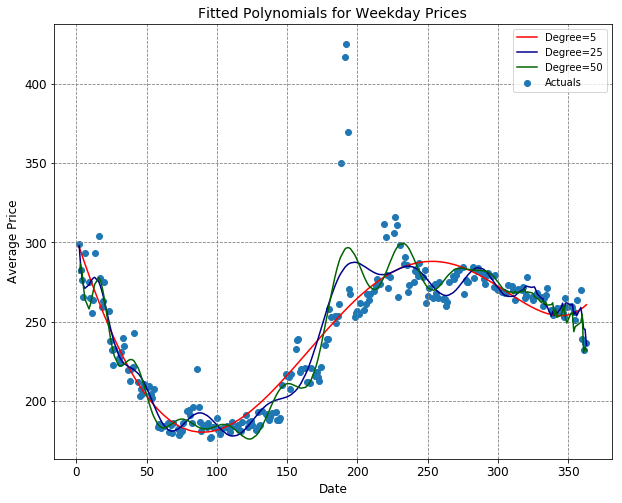

In [162]:
fig5, ax5 = plt.subplots(1,1, figsize=(10,8))
ax5.scatter(train_gb[-cond]['date_diff_min'], train_gb[-cond]['price'], label='Actuals')
ax5.plot(train_gb[-cond]['date_diff_min'], pr_train_wkdy[5], color="red", label='Degree=5')
ax5.plot(train_gb[-cond]['date_diff_min'], pr_train_wkdy[25], color="darkblue", label='Degree=25')
ax5.plot(train_gb[-cond]['date_diff_min'], pr_train_wkdy[50], color="darkgreen", label='Degree=50')
ax5.set_xlabel('Date', fontsize=12)
ax5.set_ylabel('Average Price', fontsize=12)
ax5.legend(loc='best')
ax5.grid(b=True, ls='--', color='grey')
ax5.tick_params(labelsize=12)
ax5.set_title('Fitted Polynomials for Weekday Prices', fontsize=14);

your explanation here

### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 3 most expensive dates. Given what you know about Boston, how might you explain why these 3 days happen to be so expensive?

In [163]:
#your code here
train_gb.sort_values(by='price', ascending=False)[:3]

,date_diff_min,day,date_new,price
190,190,Sat,2018-04-14,432.680761
192,192,Mon,2018-04-16,425.289528
191,191,Sun,2018-04-15,417.170404


**Answer:** 
Boston Marathon on April 16th, 2018.

### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

In [184]:
#your code here
listings_train = pd.read_csv('data\listings_train.csv')
listings_test = pd.read_csv('data\listings_test.csv')
display(listings_train.shape)
display(listings_test.shape)
display(listings_train.head())
display(listings_train.describe())

(4370, 12)

(487, 12)

,host_total_listings_count,room_type,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews
0,1,Private room,42.347956,-71.155196,1.0,1,1,52,1,65,365,26
1,85,Entire home/apt,42.349299,-71.083470,1.0,0,1,110,1,104,107,38
2,6,Entire home/apt,42.341902,-71.073792,1.0,1,1,67,45,56,322,9
3,1,Entire home/apt,42.319235,-71.105016,2.0,2,2,103,8,113,341,49
4,1,Entire home/apt,42.346452,-71.134896,1.0,0,1,8,24,82,41,13


,host_total_listings_count,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews
count,4370.000000,4370.000000,4370.000000,4370.000000,4370.000000,4370.000000,4370.000000,4370.000000,4370.000000,4370.000000,4370.000000
mean,80.321053,42.339982,-71.083952,1.244394,1.340732,1.754005,172.271396,12.036613,43.638902,157.512357,24.842563
std,222.020576,0.025242,0.032747,0.506987,0.871151,1.244862,114.965528,16.598625,38.728528,138.638960,43.774003
min,1.000000,42.235760,-71.179257,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,42.328950,-71.105020,1.000000,1.000000,1.000000,66.000000,1.000000,3.000000,10.000000,1.000000
50%,2.000000,42.345417,-71.077116,1.000000,1.000000,1.000000,147.000000,2.000000,36.000000,128.000000,7.000000
75%,11.000000,42.356017,-71.061138,1.000000,2.000000,2.000000,287.750000,24.000000,81.000000,316.000000,28.000000
max,982.000000,42.396191,-70.988496,6.000000,10.000000,16.000000,363.000000,61.000000,117.000000,365.000000,401.000000


In [185]:
def scale_num(fit_df, trans_df, non_binary: list):
    df_scaled = trans_df.copy()
    scaler = StandardScaler().fit(fit_df[non_binary])
    df_scaled[non_binary] = pd.DataFrame(scaler.transform(df_scaled[non_binary]), index=df_scaled.index, columns=non_binary)
    return(df_scaled)

In [186]:
non_binary = list(listings_train.columns[listings_train.dtypes!='object'])
list_train_scaled = scale_num(fit_df=listings_train, trans_df=listings_train, non_binary=non_binary)
list_test_scaled = scale_num(fit_df=listings_train, trans_df=listings_test, non_binary=non_binary)

C:\Users\Saurabh\Anaconda3\envs\109b\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Saurabh\Anaconda3\envs\109b\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\Saurabh\Anaconda3\envs\109b\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Saurabh\Anaconda3\envs\109b\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


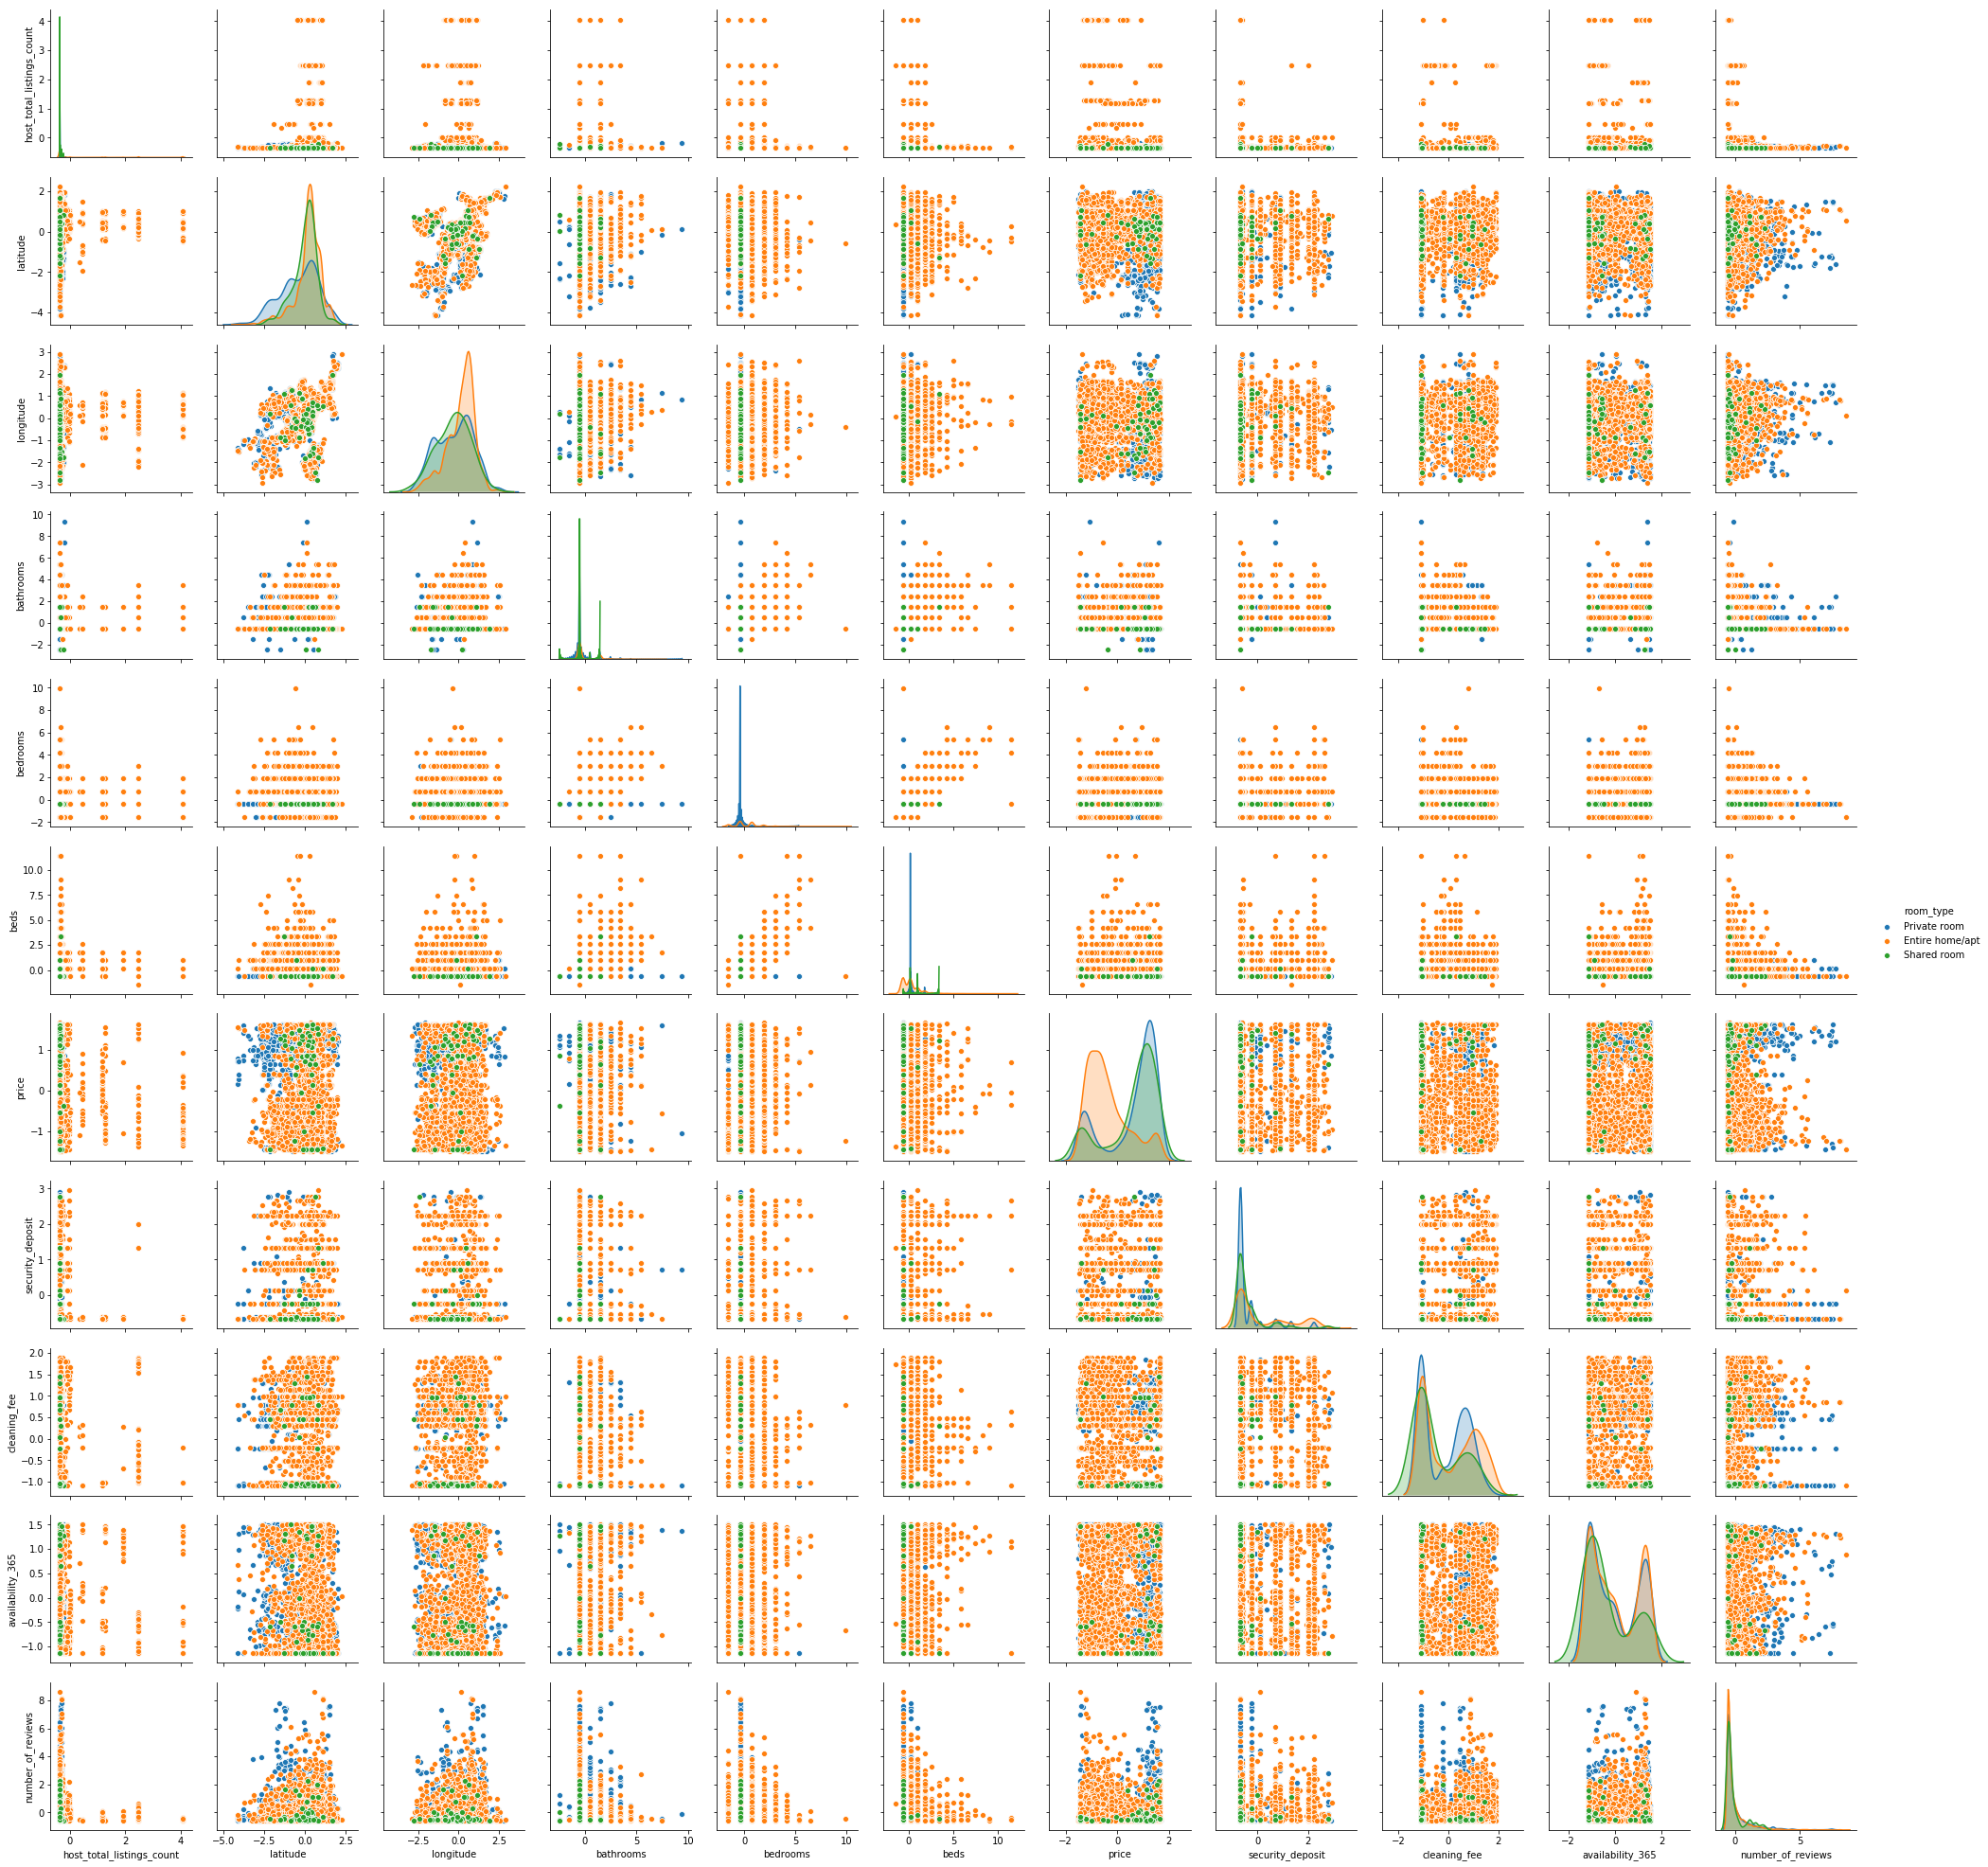

In [193]:
sns.pairplot(data=list_train_scaled, hue='room_type' )

your explanation here

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial baseis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

In [233]:
dummies = pd.get_dummies(list_train_scaled['room_type'])
list_train_scaled = pd.concat([list_train_scaled, dummies], axis=1)
dummies = pd.get_dummies(list_test_scaled['room_type'])
list_test_scaled = pd.concat([list_test_scaled, dummies], axis=1)

In [234]:
X_cols = list(set(['price','room_type'])^set(list_train_scaled.columns))

In [235]:
#your code here
lm = LinearRegression()
lm.fit(X=list_train_scaled[['price']], y=list_train_scaled[X_cols])
lm.predict(list_test_scaled[X_cols])

ValueError: shapes (487,16) and (1,22) not aligned: 16 (dim 1) != 1 (dim 0)

In [ ]:
#your code here

your explanation here

### Part 2b: Generalized Additive Model (GAM)

*Helpful Hint:  Please refer to the lecture ipynb for the code template to perform GAM*

Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


In [ ]:
#your code here

In [ ]:
#your code here

your explanation here

### Part 2c: Putting it All Together

Based on your analysis for problems 1 and 2, what advice would you give a frugal visitor to Boston looking to save some money on an Airbnb rental?



your explanation here

your explanation here